In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
train = pd.read_csv("../input/ensembling-and-stacking-gpu-models/ensemble_req.csv")
test = pd.read_csv("../input/ensembling-and-stacking-gpu-models/test_req.csv").iloc[:, 1:-1].values

X_train = train.iloc[:, 1:-1].values
y_train = pd.get_dummies(train["label"]).values

# ANN Model

In [3]:
class ANNModel(nn.Module):
    def __init__(self, input_shape, hidden1, hidden2, hidden3, outshape):
        self.input_shape = input_shape
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.hidden3 = hidden3
        self.hidden4 = hidden4
        self.outshape = outshape
        
        super().__init__()
        
        self.fc1 = nn.Linear(self.input_shape, self.hidden1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(self.hidden2, self.hidden3)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(self.hidden3, self.hidden3)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(self.hidden3, self.hidden4)
        self.relu5 = nn.ReLU()
        
        self.final = nn.Linear(self.hidden4, self.outshape)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        out = self.relu4(out)
        
        out = self.fc5(out)
        out = self.relu5(out)
        
        out = self.final(out)
        
        return out
    

input_shape = 10 
hidden1 = 30
hidden2 = 40
hidden3 = 40
hidden4 = 16
outshape = 4



model = ANNModel(input_shape,
                    hidden1,
                    hidden2,
                    hidden3,
                    outshape)


In [4]:
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        self.confidence = 1 - smoothing
        self.smoothing = smoothing
        super().__init__()
        
    def forward(self, x, target):
            x = x.float()
            target = target.float()
            
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)
            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss
            return loss.mean()

In [6]:
X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)
test_data = torch.from_numpy(test).type(torch.FloatTensor)

In [7]:
train = torch.utils.data.TensorDataset(X, y)
test = torch.utils.data.TensorDataset(test_data)

In [8]:
train_loader = DataLoader(train, batch_size = 32, shuffle = True)
test_loader = DataLoader(test, batch_size = 32, shuffle = False)

In [9]:
for epoch in range(10):
    for i, (X, y) in enumerate(train_loader):
        xtr = Variable(X)
        ytr = Variable(y)
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(xtr)
        
        # Calculate softmax and ross entropy loss
        lossClass = LabelSmoothing()
        loss = lossClass.forward(outputs, ytr)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
    if epoch % 10 == 0:    
        print(f"loss = {loss.item()} \t epoch no {epoch}")

loss = 1.3757556676864624 	 epoch no 0


In [10]:
results = []

for i, (X) in enumerate(test_loader):
#     print(X)
    xte = Variable(X[0])
    preds = model(xte)
    y_pred = 1 - nn.functional.softmax(preds, dim=1).detach().numpy()[:,0]
    results.extend(y_pred)
    
    print(i, end = "\r")

In [11]:
df = pd.DataFrame()
df["Id"] = pd.read_csv("../input/ensembling-and-stacking-gpu-models/test_req.csv").iloc[:, -1].values
df["Label"] = results

In [12]:
df.set_index("Id", inplace = True)

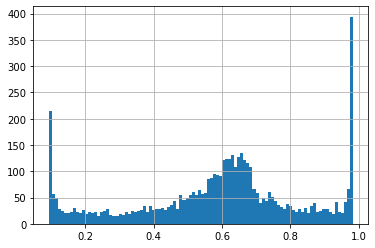

In [13]:
( df["Label"]).hist(bins= 100)

In [14]:
df.to_csv("submission.csv")